<a href="https://colab.research.google.com/github/Deleon57/EDAR-Data/blob/main/SVM222.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Get Data

In [2]:
ticker = "GFI.JO"
data = yf.download(ticker, start="2013-01-01", end="2024-12-31")

data.reset_index(inplace=True)
data.head(10)

/tmp/ipython-input-3713280938.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2013-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO
0,2013-01-01,9091.969727,9091.969727,9091.969727,9091.969727,0
1,2013-01-02,9323.317383,9325.945528,9043.766744,9151.555749,2277190
2,2013-01-03,9335.583984,9376.772209,9183.978625,9289.138496,1638359
3,2013-01-04,9049.025391,9131.400891,8955.257690,9113.874727,2154183
4,2013-01-07,9104.234375,9156.813836,9000.826901,9083.202396,1833898
5,2013-01-08,8928.092773,9148.052382,8900.926828,9013.973126,2221997
6,2013-01-09,9006.960938,9037.632696,8860.613781,9020.982257,2344840
7,2013-01-10,9091.969727,9091.969727,8906.186671,8982.428240,1564839
8,2013-01-11,9201.506836,9240.065951,9112.997380,9113.874078,3899959


# Feature engineer

In [3]:
df = data.copy()

# 1. Spreads
df['High_Low'] = df['High'] - df['Low']
df['Open_Close'] = df['Open'] - df['Close']

# 2. Moving Averages
df['SMA_5'] = df['Close'].rolling(5).mean()
df['SMA_10'] = df['Close'].rolling(10).mean()
df['SMA_20'] = df['Close'].rolling(20).mean()
df['SMA_50'] = df['Close'].rolling(50).mean()
df['SMA_100'] = df['Close'].rolling(100).mean()
df['SMA_200'] = df['Close'].rolling(200).mean()

# 3. Exponential Moving Averages
df['EMA_5'] = df['Close'].ewm(span=5, adjust=False).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()

# 4. Rolling Std (Volatility)
df['RollingStd_20'] = df['Close'].rolling(20).std()

# 5. Lag Features (Close & Volume)
for lag in range(1, 6):
    df[f'Close_t-{lag}'] = df['Close'].shift(lag)
    df[f'Volume_t-{lag}'] = df['Volume'].shift(lag)
    df[f'Return_t-{lag}'] = df['Close'].pct_change(lag)

# 6. Relative Strength Index (RSI)
window_length = 14
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
rs = gain / loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# 7. On-Balance Volume (OBV)
df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

# 8. Moving Average Convergence Divergence (MACD)
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# 9. Bollinger Bands (20-day)
df['BB_Middle'] = df['Close'].rolling(window=20).mean()

# 10. Average True Range (ATR)
df['H-L'] = df['High'] - df['Low']
df['H-C'] = abs(df['High'] - df['Close'].shift())
df['L-C'] = abs(df['Low'] - df['Close'].shift())
df['TR'] = df[['H-L', 'H-C', 'L-C']].max(axis=1)
df['ATR_14'] = df['TR'].rolling(14).mean()

# Drop NA rows
df.dropna(inplace=True)

# Target: 1 if next-day close > today’s close, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

df.dropna(inplace=True)
df.head(10)

Price,Date,Close,High,Low,Open,Volume,High_Low,Open_Close,SMA_5,SMA_10,...,EMA_26,MACD,Signal_Line,BB_Middle,H-L,H-C,L-C,TR,ATR_14,Target
Ticker,,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,,,,,...,,,,,,,,,,
199,2013-10-07,4485.153809,4575.934279,4452.233418,4479.168283,1173121,123.700861,-5.985526,4500.716211,4591.397168,...,4838.440353,-222.953598,-231.006055,4695.545166,123.700861,80.803908,42.896953,123.700861,162.749089,0
200,2013-10-08,4451.236816,4556.981124,4449.241641,4556.981124,1274177,107.739484,105.744308,4497.125098,4562.068115,...,4809.758609,-219.541076,-228.713059,4660.230640,107.739484,71.827316,35.912168,107.739484,163.532909,0
201,2013-10-09,4380.407715,4470.190610,4355.468022,4464.205084,1392042,114.722589,83.797369,4467.995801,4531.242627,...,4777.954839,-220.015739,-226.973595,4627.858936,114.722589,18.953794,95.768795,114.722589,146.859077,1
202,2013-10-10,4442.257324,4468.194600,4301.597481,4375.418959,1802995,166.597120,-66.838365,4450.837207,4506.402686,...,4753.088357,-212.946453,-224.168167,4609.902368,166.597120,87.786885,78.810234,166.597120,139.662226,0
203,2013-10-11,4336.512207,4429.287831,4302.594237,4406.343321,1050501,126.693593,69.831114,4419.113574,4471.187646,...,4722.230864,-213.416606,-222.017855,4590.299731,126.693593,12.969494,139.663087,139.663087,134.959370,1
204,2013-10-14,4399.362305,4436.273054,4279.651766,4321.550454,2032833,156.621288,-77.811850,4401.955273,4451.335742,...,4698.314675,-206.339179,-218.882120,4578.079321,156.621288,99.760847,56.860441,156.621288,146.146605,0
205,2013-10-15,4336.512207,4406.343321,4271.669029,4372.425352,2081226,134.674292,35.913145,4379.010352,4438.067725,...,4671.514492,-203.456425,-215.796981,4561.519312,134.674292,6.981017,127.693275,134.674292,143.225106,1
206,2013-10-16,4369.434570,4488.147519,4344.494875,4366.441807,2451447,143.652643,-2.992763,4376.815723,4422.405762,...,4649.138201,-196.252980,-211.888180,4545.557910,143.652643,151.635312,7.982668,151.635312,143.724042,1
207,2013-10-17,4424.300781,4424.300781,4289.626462,4329.529964,7904643,134.674319,-94.770817,4373.224414,4412.030811,...,4632.483578,-183.995962,-206.309737,4521.665723,134.674319,54.866211,79.808108,134.674319,142.940221,1


#Train and split data

In [7]:
train = df[df['Date'] < "2024-01-01"]
test = df[df['Date'] >= "2024-01-01"]

feature_pool = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'SMA_5','SMA_10','SMA_20','SMA_50','SMA_100','SMA_200',
    'EMA_5','EMA_20','EMA_50',
    'RollingStd_20','High_Low','Open_Close',
    'Close_t-1','Close_t-2','Close_t-3','Close_t-4','Close_t-5',
    'Volume_t-1','Volume_t-2','Volume_t-3','Volume_t-4','Volume_t-5',
    'Return_t-1','Return_t-2','Return_t-3','Return_t-4','Return_t-5',
    'RSI_14',
    'OBV','EMA_12','EMA_26','MACD','Signal_Line','BB_Middle',
    'H-L','H-C','L-C','TR','ATR_14'
]
X_train_full = train[feature_pool]
y_train = train['Target']
X_test_full = test[feature_pool]
y_test = test['Target']


# Search for best combinations of features for highest accuracy

In [ ]:
import random
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

best_score = 0
best_features = None
best_model = None

for _ in range(200):
    # Randomly choose number of features (between 2 and 10)
    r = random.randint(2, 10)
    combo = random.sample(feature_pool, r)

    X_train = X_train_full[list(combo)]
    X_test = X_test_full[list(combo)]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = SVC(kernel='rbf', C=1.0, gamma='scale')
    model.fit(X_train_scaled, y_train)

    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)


    if acc > best_score:
        best_score = acc
        best_features = combo
        best_model = model

print("Best Accuracy:", best_score)
print("Best Feature Set:", best_features)


# Confusion matrix

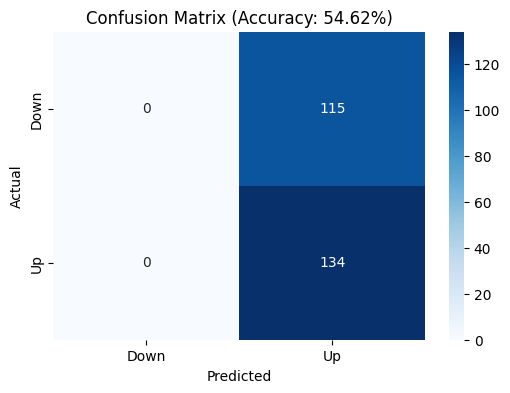

In [22]:
X_test_best = X_test_full[list(best_features)]
y_pred = best_model.predict(X_test_best)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Down","Up"], yticklabels=["Down","Up"])
plt.title(f"Confusion Matrix (Accuracy: {best_score:.2%})")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


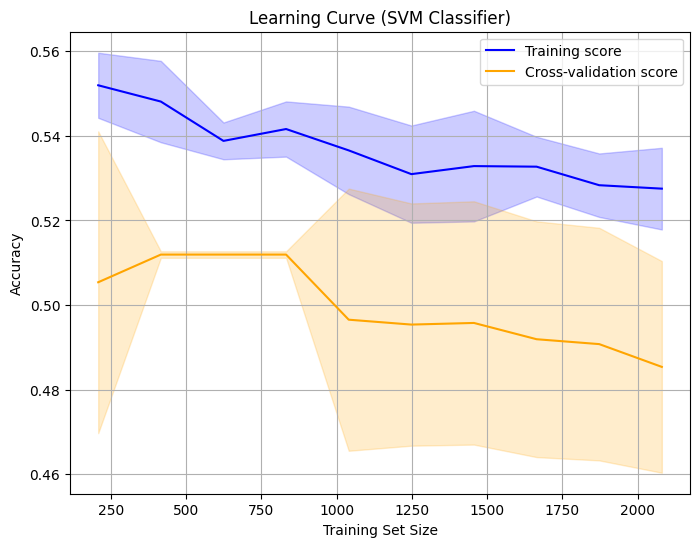

In [23]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model,
    X_train_full[list(best_features)],
    y_train,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label="Training score", color="blue")
plt.plot(train_sizes, test_mean, label="Cross-validation score", color="orange")

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2, color="orange")

plt.title("Learning Curve (SVM Classifier)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()
